In [ ]:
!pip install awswrangler

In [2]:
import awswrangler as wr
import boto3
import pandas as pd
import numpy as np
import re
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
from tqdm import tqdm 

role = get_execution_role()
s3 = boto3.resource('s3')

In [3]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('icusics-db')

tables = []
for my_bucket_object in my_bucket.objects.all():
    tables.append(my_bucket_object.key)
tables = pd.Series(tables)

In [4]:
variables = wr.s3.read_parquet(path="s3://icusics-db/d_variables/d_variables.parquet")
variables_h4 = variables[variables.hospital_coded==4]
diagnoses = wr.s3.read_parquet(path="s3://icusics-db/diagnoses/diagnoses_h4.parquet")
labresults_numeric = wr.s3.read_parquet(path="s3://icusics-db/labresults_numeric/labresults_numeric_h4.parquet")

# Check for predictors variable_id

Predictors:
 - Albumine
 - Potassium
 - SpO2
 - Haematocrit
 - Ph
 - Blood Urine Nitrate / Urea * 0.357
 - Diabetes
 - Chronic Kidney Disease
 - Hyper tension
 - Heart failure

Outcome:
 - CRRT

In [9]:
# Albumine

alb_idx = [
    1024000512,2024000340,3024001802,
    4024002341,5024001802,6024002862
]

albumine = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(alb_idx)]
    tot.append(ith)
    ith = ith[ith.time<=24*60]
    if i == 1:
        ith.loc[:,'value'] = ith.loc[:,'value'] / 10
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    albumine.append(ith)
    
albumine = pd.concat(albumine)

#albumine.to_csv('./tmp/tmp_table.csv')
#albumine = pd.read_csv('./tmp/tmp_table.csv', index_col=0)

albumine

  0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


value      
             amin  amax
a_patientid            
1000091      2.43  2.43
1000109      2.68  3.01
1002069      1.86  2.16
1002635      3.32  3.32
1002875      2.15  2.15
...           ...   ...
6997183      3.30  4.40
6998109      3.80  3.80
6998565      3.50  3.50
6998846      3.50  3.50
6999255      3.00  3.00

[9720 rows x 2 columns]

In [25]:
tot = pd.concat(tot)

m0 = tot[tot.time>=0]
n_days = 2
b = np.linspace(0,n_days*24*60,100)
ax = m0.groupby('a_patientid').time.min().hist(bins=b)
_ = ax.set_title('First Albumine exam time distribution')
_ = ax.set_xticks([i*60*6 for i in range(n_days*4)])
_ = ax.set_xticklabels([i*6 for i in range(n_days*4)])
_ = ax.set_xlabel('Time [hours]')
plt.show()

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [21]:
# Potassium

potassium_idx = [
    1020000500,2020000500,3020000500,
    4020000500,5020000500,6020000500
]

potassium = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(potassium_idx)]
    tot.append(ith)
    ith = ith[ith.time<24*60]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    potassium.append(ith)
    
potassium = pd.concat(potassium)

potassium.to_csv('./tmp/tmp_table.csv')
potassium = pd.read_csv('./tmp/tmp_table.csv', index_col=0)

potassium

100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


,value,value.1
NaN,amin,amax
a_patientid,NaN,NaN
1000091,2.99,2.99
1000109,2.5,3.9
1000211,4.47,4.47
...,...,...
6998109,3.8,3.8
6998382,3.68,4.63
6998565,3.79,3.81
6998846,4.06,4.57


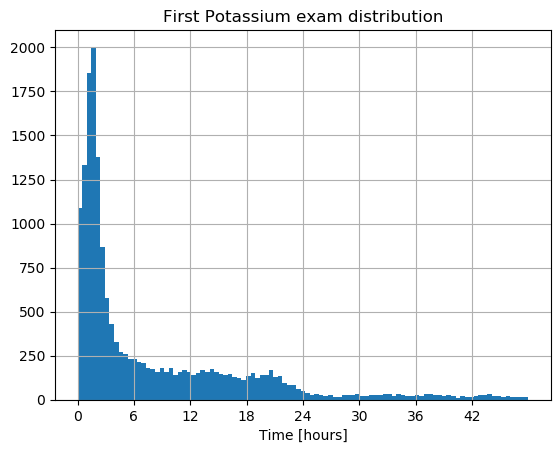

In [22]:
tot = pd.concat(tot)

m0 = tot[tot.time>=0]
n_days = 2
b = np.linspace(0,n_days*24*60,100)
ax = m0.groupby('a_patientid').time.min().hist(bins=b)
_ = ax.set_title('First Potassium exam distribution')
_ = ax.set_xticks([i*60*6 for i in range(n_days*4)])
_ = ax.set_xticklabels([i*6 for i in range(n_days*4)])
_ = ax.set_xlabel('Time [hours]')
plt.show()

In [24]:
# SpO2

idx = [
    1000004000,2000004000,3000004000,
    4000004000,5000004000,6000004000, # SpO2
]

spo2 = []
for tbl_name in tqdm(tables.str.extract('(.*monitored_numeric.*)').dropna()[0]):
    ith_monitored = wr.s3.read_parquet(f's3://icusics-db/{tbl_name}')
    ith = ith_monitored[ith_monitored.a_variableid.isin(idx)]
    ith = ith[ith.time<12*60]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    spo2.append(ith)

spo2 = pd.concat(spo2)

spo2.to_csv('./tmp/tmp_table.csv')
spo2 = pd.read_csv('./tmp/tmp_table.csv', index_col=0)

spo2

100%|██████████| 600/600 [04:47<00:00,  2.09it/s]


,value,value.1
NaN,amin,amax
a_patientid,NaN,NaN
1000091,76.0,100.0
1000109,90.0,100.0
1000211,96.0,100.0
...,...,...
6998109,97.0,100.0
6998382,91.0,100.0
6998565,87.0,100.0
6998846,85.0,100.0


In [ ]:
ith.to_csv('./tmp/asd.csv')
ith = pd.read_csv('./tmp/asd.csv', index_col=0)

ith.groupby('a_patientid').agg({'value':[np.min, np.max]})

In [ ]:
tables.str.extract('(.*monitored_numeric.*)').dropna().values[0]

In [ ]:
# SpO2
idx = variables_h4.name.str.lower().str.extract(r'(.*(\bspo2\b|\bsatura\w+).*)')[0].dropna().index.tolist()
variables_h4.loc[idx]

In [ ]:
# Haematocrit
idx = variables_h4.name.str.lower().str.extract(r'(.*ha?emat\w+.*)')[0].dropna().index.tolist()
variables_h4.loc[idx]

In [ ]:
# Ph
idx = variables_h4.name.str.lower().str.extract(r'(.*ph.*)')[0].dropna().index.tolist()
variables_h4.loc[idx]

In [ ]:
# Blood Urine Nitrate
# urea * 0.357
idx = variables_h4.name.str.lower().str.extract(r'(.*urea.*)')[0].dropna().index.tolist()
variables_h4.loc[idx]

In [ ]:
# Diabetes
idx = diagnoses.referencecodename.str.extract(r'(.*[Dd]iabe.*)').dropna().index.tolist()
diabetes_codes = diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates().referencecode
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()

In [ ]:
# Chronic Kidney Disease
idx = diagnoses.referencecodename.str.lower().str.extract(r'(.*renal cr\wnica.*)').dropna().index.tolist()
ckd_codes = diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates().referencecode
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()

In [ ]:
# Hyper tension
idx = diagnoses.referencecodename.str.lower().str.extract(r'(.*hipertens.*)').dropna().index.tolist()
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()#.referencecodename.value_counts()

In [ ]:
# Heart failure
idx = diagnoses.referencecodename.str.lower().str.extract(r'(.*insufici\wncia card\waca.*)').dropna().index.tolist()
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()#.referencecodename.value_counts()

In [ ]:
diagnosis_codes = [
    # diabetes_codes
    # ckd_codes
    'I10','401.1','402.11','I15.8','I15.0','I11','I15','I13.1','I11.9','I15.1','I11.0','I11.0','401.9' # hyptertension
    'I50','I50.9','428.0','402.11','I50.2','I50.9','I11.0' # heart failure
] + list(diabetes_codes) + list(ckd_codes)

comorbidities = diagnoses[diagnoses.referencecode.isin(diagnosis_codes)]
comorbidities

In [ ]:
# CRRT
idx = variables_h4.name.str.lower().str.extract(r'(.*\bfl\wx.*)')[0].dropna().index.tolist()
variables_h4.loc[idx]

In [ ]:
lab_items = [
    4024002341, # Albumine
    4020000500, # Potassium
    4020000100, # Haematocrit
    4024001491, # Ph
    4020004100, # BUN
]

lab_predictors = labresults_numeric[labresults_numeric.a_variableid.isin(lab_items)]
lab_predictors = lab_predictors.merge(variables.loc[:, ['a_variableid','abbreviation']], how='left', on='a_variableid')
lab_predictors

In [ ]:
tmp_path = './tmp/labs.csv'
#lab_predictors.to_csv(tmp_path)
lab_predictors = pd.read_csv(tmp_path, index_col=0)
lab_predictors

In [ ]:
vital_items = [
    4000004000, # SpO2
]

outcome_items = [
    4000001380, # Flux Sang
    4000005666, # Flux Efluent
]

monitored_predictors = []
outcomes = []

monitored_tables = tables[tables.str.match(r'monitored_numeric/monitored_numeric_4')]
for table in tqdm(monitored_tables):
    t_ith = wr.s3.read_parquet(path=f"s3://icusics-db/{table}")
    v_ith = t_ith[t_ith.a_variableid.isin(vital_items)]
    o_th = t_ith[t_ith.a_variableid.isin(outcome_items)]
    monitored_predictors.append(v_ith)
    outcomes.append(o_th)
    
monitored_predictors = pd.concat(monitored_predictors, ignore_index=True)
outcomes = pd.concat(outcomes, ignore_index=True)
outcomes

In [ ]:
outcomes = outcomes.merge(variables.loc[:, ['a_variableid','abbreviation']], how='left', on='a_variableid')
tmp_path = './tmp/outcomes.csv'
outcomes.to_csv(tmp_path)
outcomes = pd.read_csv(tmp_path, index_col=0)
outcomes

In [ ]:
#monitored_predictors = monitored_predictors.merge(variables.loc[:, ['a_variableid','abbreviation']], how='left', on='a_variableid')
tmp_path = './tmp/vitals.csv'
#monitored_predictors.to_csv(tmp_path)
monitored_predictors = pd.read_csv(tmp_path, index_col=0)
monitored_predictors

In [ ]:
lower_bound = 12 * 60
upper_bound = 5 * 24 * 60

labs = lab_predictors.query(f"time<={lower_bound}")
vitals = monitored_predictors.query(f"time<={lower_bound}")

vitals = pd.pivot_table(
    vitals,
    index='a_patientid',
    columns='abbreviation',
    values='value',
    aggfunc=[min,max]
).reset_index()

labs = pd.pivot_table(
    labs,
    index='a_patientid',
    columns='abbreviation',
    values='value',
    aggfunc=[min,max]
).reset_index()

labs

# features = vitals.merge(labs, how='inner', on='a_patientid')

In [ ]:
vitals

In [ ]:
labs.columns = list(map(lambda t: t[0] + '_' + t[1], labs.columns))
vitals.columns = list(map(lambda t: t[0] + '_' + t[1], vitals.columns))

features = vitals.merge(labs, how='inner', on='a_patientid_').rename(columns={'a_patientid_': 'a_patientid'})
features

In [ ]:
comorbidities['diabetis_flag'] = comorbidities.referencecodename.str.lower().str.match(r'.*diabet.*').astype(int)
comorbidities['ckd_flag'] = comorbidities.referencecodename.str.lower().str.match(r'.*renal cr.nica.*').astype(int)
comorbidities['hyperTension_flag'] = comorbidities.referencecodename.str.lower().str.match(r'.*hipertens.*').astype(int)
comorbidities['heartFailure_flag'] = comorbidities.referencecodename.str.lower().str.match(r'.*insufici\wncia card\waca.*').astype(int)

df_comorb = comorbidities.groupby('a_patientid').agg(dict.fromkeys(comorbidities.columns[-4:], 'max')).reset_index()
df_comorb

In [ ]:
features_v2 = features.merge(df_comorb, how='left', on='a_patientid')

for col in df_comorb.columns[1:]:
    features_v2[col] = features_v2[col].fillna(0)
    
features_v2

In [ ]:
target = pd.pivot_table(
    outcomes,
    index=['a_patientid','time'],
    columns=['a_variableid'],
    values='value'
).reset_index()

target = target.rename(columns={4000001380:'flux_sang', 4000005666:'flux_efluent'})
#tmp_path = './tmp/target.csv'
#target.to_csv(tmp_path)
#target = pd.read_csv(tmp_path, index_col=0)
target

In [ ]:
target['Y'] = list(map(lambda x,y: 1 if x>=0 and y>=0 else 0, target.flux_sang.fillna(-1), target.flux_efluent.fillna(-1)))  
first_crrt = target.query('Y==1').groupby('a_patientid').time.min().reset_index()
u_target = target.merge(first_crrt, how='inner', on=['a_patientid','time'])

dataset = features_v2.merge(u_target.loc[:, ['a_patientid','time','Y']], how='left', on='a_patientid')

dataset.time = dataset.time.fillna(-1)
dataset.Y = dataset.Y.fillna(0)

#dataset_v2 = dataset.query("time<0 or time>=820")#.drop(columns=['time'])
dataset

In [ ]:
dataset.isna().sum() / dataset.shape[0]